# Biodiversity Intactness Index Change in Phoenix, Arizona (2017-2020)

**Author:** Emily Miller  
**GitHub Repository:** https://github.com/rellimylime/phoenix-bii-analysis-2017-2020

## About

### Purpose
This notebook analyzes changes in the Biodiversity Intactness Index (BII) in the Phoenix subdivision between 2017 and 2020. The analysis examines the impact of urban expansion on biodiversity, focusing on areas where BII values declined during this period. Maricopa County experienced the largest increase in developed land among U.S. counties between 2001 and 2021, making this analysis critical for understanding urbanization's ecological impact.

### Highlights
- Accessing and processing raster data from the Microsoft Planetary Computer STAC catalog using `pystac_client` and `odc-stac`
- Calculating percentage of area meeting biodiversity thresholds (BII ≥ 0.75) using raster masking and pixel counting
- Identifying spatial patterns of biodiversity loss by comparing multi-temporal raster datasets
- Creating contextualized maps using `contextily` for basemaps and `geopandas` for vector overlay

### About the Data

**Biodiversity Intactness Index (BII) Time Series**  
The BII measures the average abundance of naturally occurring species relative to their abundance in undisturbed ecosystems. Values range from 0 to 1, with 1 representing intact biodiversity. This analysis uses BII rasters for 2017 and 2020 from the Microsoft Planetary Computer's io-biodiversity collection, covering the Phoenix subdivision area (bounding box: -112.826843, 32.974108, -111.184387, 33.863574).

**Phoenix Subdivision Shapefile**  
County subdivision boundary for Phoenix from the U.S. Census Bureau's TIGER/Line shapefiles, used to define the study area and clip raster data.

### References
1. Microsoft Planetary Computer. (n.d.). *io-biodiversity*. Retrieved from https://planetarycomputer.microsoft.com/dataset/io-biodiversity
2. U.S. Census Bureau. (n.d.). *TIGER/Line Shapefiles: County Subdivisions*. Retrieved from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

---

## Setup and Imports

In [1]:
# Load required libraries
import numpy as np
import geopandas as gpd
import rioxarray as rxr
import pystac_client
import planetary_computer
import matplotlib.pyplot as plt
import contextily as ctx

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

### Load Phoenix Subdivision Boundary

To focus our analysis on the Phoenix area, we first load the Phoenix subdivision boundary from a Census shapefile. This boundary will be used to clip the BII raster data so that calculations and visualizations are restricted to the relevant geographic region.

In [2]:
# Load Phoenix subdivision shapefile
phoenix_gdf = gpd.read_file('data/tl_2020_04_cousub/tl_2020_04_cousub.shp')

# Filter for Phoenix subdivision only
phoenix_gdf = phoenix_gdf[phoenix_gdf['NAME'] == 'Phoenix'].copy()

# Check the current CRS and reproject to EPSG:4326 if needed for STAC queries
print(f"Original CRS: {phoenix_gdf.crs}")
phoenix_gdf_wgs84 = phoenix_gdf.to_crs('EPSG:4326')

# Display basic information
print(f"Phoenix subdivision geometry type: {phoenix_gdf_wgs84.geometry.type.values[0]}")
print(f"Bounds: {phoenix_gdf_wgs84.total_bounds}")

Original CRS: EPSG:4269
Phoenix subdivision geometry type: Polygon
Bounds: [-112.47014852   33.29026178 -111.58062508   33.81396778]


### Access BII Data from Microsoft Planetary Computer

Next, we access the Biodiversity Intactness Index (BII) raster datasets for 2017 and 2020 using the Microsoft Planetary Computer STAC API. We use a bounding box that covers the Phoenix subdivision to retrieve only the relevant data.

In [3]:
# Define bounding box for Phoenix area
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Connect to Microsoft Planetary Computer STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace
)

# Search for BII data covering the Phoenix area
search = catalog.search(
    collections = ["io-biodiversity"],
    bbox = bbox
)

# Retrieve items
items = search.item_collection()
print(f"Found {len(items)} items in the io-biodiversity collection")

# Examine available items
for item in items:
    print(f"Item ID: {item.id}, Datetime: {item.datetime}\"")

Found 4 items in the io-biodiversity collection
Item ID: bii_2020_34.74464974521749_-115.38597824385106_cog, Datetime: None"
Item ID: bii_2019_34.74464974521749_-115.38597824385106_cog, Datetime: None"
Item ID: bii_2018_34.74464974521749_-115.38597824385106_cog, Datetime: None"
Item ID: bii_2017_34.74464974521749_-115.38597824385106_cog, Datetime: None"


In [4]:
# Filter items for 2017 and 2020
items_2017 = [item for item in items if '2017' in item.id]
items_2020 = [item for item in items if '2020' in item.id]

print(f"Found {len(items_2017)} items for 2017")
print(f"Found {len(items_2020)} items for 2020")

# Load 2017 and 2020 BII rasters using rioxarray with STAC item hrefs
# Get the first item from each year
item_2017 = items_2017[0]
item_2020 = items_2020[0]

# Access the data using the asset href
bii_2017 = rxr.open_rasterio(item_2017.assets['data'].href)
bii_2020 = rxr.open_rasterio(item_2020.assets['data'].href)

# Check data structure
print("\n2017 BII data:")
print(bii_2017)
print("\n2020 BII data:")
print(bii_2020)

Found 1 items for 2017
Found 1 items for 2020

2017 BII data:
<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

2020 BII data:
<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


## Data Exploration

Examine the BII raster properties and value distributions to understand the data before analysis.

In [6]:
# Explore BII data structure and values
# Check CRS
print(f"2017 CRS: {bii_2017.rio.crs}")
print(f"2020 CRS: {bii_2020.rio.crs}")

# Check resolution
print(f"\n2017 resolution: {bii_2017.rio.resolution()}")
print(f"2020 resolution: {bii_2020.rio.resolution()}")

# Check shape and dimensions
print(f"\n2017 shape: {bii_2017.shape}")
print(f"2020 shape: {bii_2020.shape}")

2017 CRS: EPSG:4326
2020 CRS: EPSG:4326

2017 resolution: (0.0008983152841195215, -0.0008983152841195215)
2020 resolution: (0.0008983152841195215, -0.0008983152841195215)

2017 shape: (1, 7992, 7992)
2020 shape: (1, 7992, 7992)


In [8]:
# Check value ranges
print(f"\n2017 BII range: {bii_2017.min().values} to {bii_2017.max().values}")
print(f"2020 BII range: {bii_2020.min().values} to {bii_2020.max().values}")

# Check for NoData values
print(f"\n2017 NoData value: {bii_2017.rio.nodata}")
print(f"2020 NoData value: {bii_2020.rio.nodata}")


2017 BII range: 0.07058961689472198 to 0.9936540722846985
2020 BII range: 0.08015034347772598 to 0.9936537146568298

2017 NoData value: None
2020 NoData value: None


## Geographic Context Map

Create a map that shows the location of the Pheonix subdivisoin within the broader region. This visualization uses a basemap for geographic context and overlays the Phoenix boundary for reference.

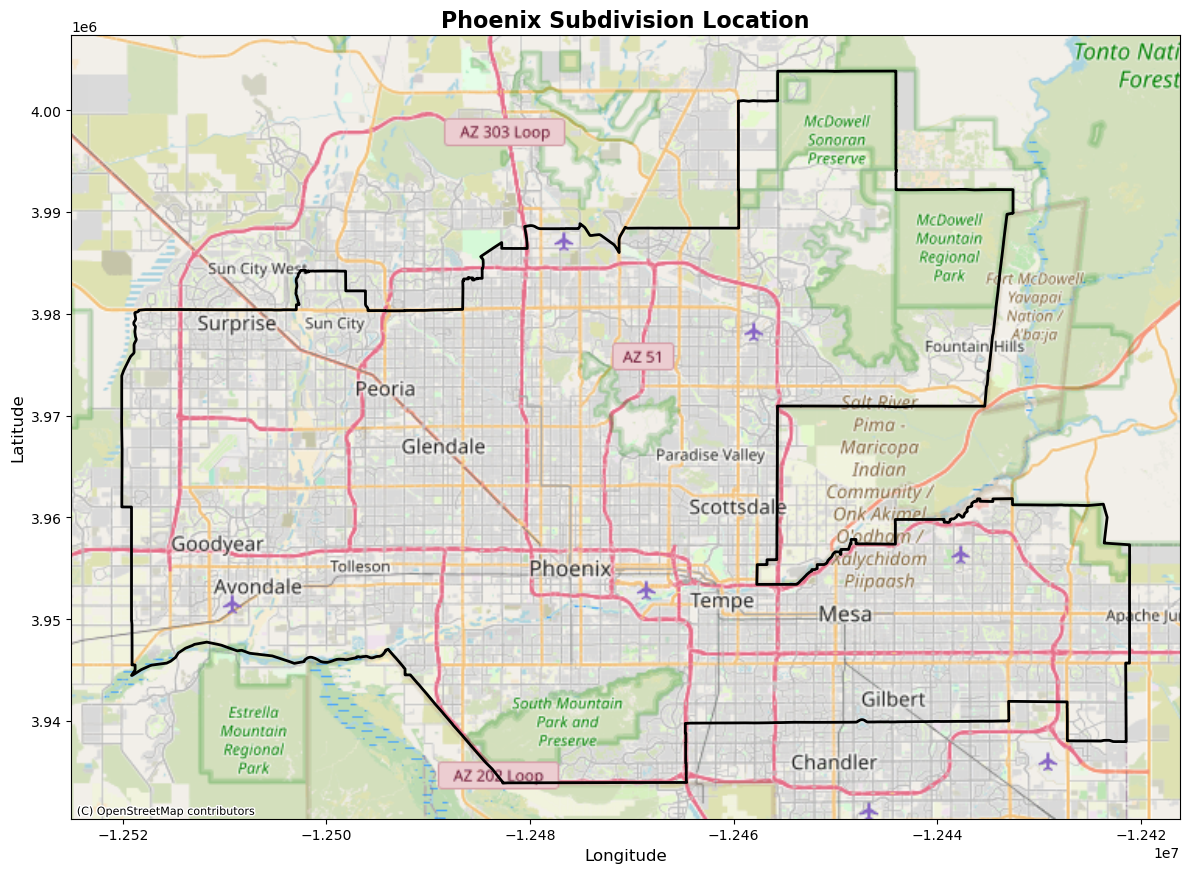

In [9]:
# Reproject Phoenix boundary to Web Mercator for contextily basemap
phoenix_merc = phoenix_gdf_wgs84.to_crs('EPSG:3857')

fig, ax = plt.subplots(figsize=(12, 10))

# Plot Phoenix subdivision
phoenix_merc.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, label='Phoenix Subdivision')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Formatting
ax.set_title('Phoenix Subdivision Location', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
#ax.legend()

plt.tight_layout()
plt.show()

## BII Analysis

### Calculate Percentage of Area with BII $\geq$ 0.75

To quantify high-biodiversity areas, we calculate the percentage of the Phoenix subdivision with BII values greater than or equal to 0.75 for both 2017 and 2020. This involves reprojecting the boundary to match the raster CRS and clipping the rasters to the subdivision extent.

In [10]:
# Reproject Phoenix boundary to match BII raster CRS
phoenix_raster_crs = phoenix_gdf.to_crs(bii_2017.rio.crs)

# Clip rasters to Phoenix boundary
bii_2017_clipped = bii_2017.rio.clip(phoenix_raster_crs.geometry, phoenix_raster_crs.crs, drop = True)
bii_2020_clipped = bii_2020.rio.clip(phoenix_raster_crs.geometry, phoenix_raster_crs.crs, drop = True)

print(f"2017 clipped shape: {bii_2017_clipped.shape}")
print(f"2020 clipped shape: {bii_2020_clipped.shape}")


2017 clipped shape: (1, 583, 990)
2020 clipped shape: (1, 583, 990)


Now we count the number of pixels within the Phoenix subdivision that meet the BII threshold (≥ 0.75) and calculate the percentage relative to the total valid area.

In [11]:
# Create mask for BII >= 0.75
mask_2017_high = bii_2017_clipped >= 0.75
mask_2020_high = bii_2020_clipped >= 0.75

# Count pixels meeting threshold
count_2017_high = mask_2017_high.sum().values
count_2020_high = mask_2020_high.sum().values

# Create mask for valid data
valid_2017 = ~np.isnan(bii_2017_clipped.values)
valid_2020 = ~np.isnan(bii_2020_clipped.values)

# Count total valid pixels
count_2017_total = valid_2017.sum()
count_2020_total = valid_2020.sum()

# Calculate percentage 
pct_2017 = (count_2017_high / count_2017_total) * 100
pct_2020 = (count_2020_high / count_2020_total) * 100

print(f"Percentage of Phoenix area with BII ≥ 0.75 in 2017: {pct_2017:.2f}%")
print(f"Percentage of Phoenix area with BII ≥ 0.75 in 2020: {pct_2020:.2f}%")
print(f"Change: {pct_2020 - pct_2017:.2f} percentage points")

Percentage of Phoenix area with BII ≥ 0.75 in 2017: 7.13%
Percentage of Phoenix area with BII ≥ 0.75 in 2020: 6.49%
Change: -0.63 percentage points


### Visualize Areas of BII Loss

We now visualize areas that experienced a loss in high biodiversity. Specifically, we identify regions where BII was ≥ 0.75 in 2017 but dropped below this threshold by 2020. This helps highlight the spatial impact of urban expansion on biodiversity.

In [12]:
# High BII 2017 mask
high_2017 = mask_2017_high

# Low BII 2020 mask
low_2020 = bii_2020_clipped < 0.75

# Remove the time dimension since we only have one time per dataset
high_2017_squeeze = high_2017.squeeze()
low_2020_squeeze = low_2020.squeeze()

# BII loss mask
loss_areas = high_2017_squeeze & low_2020_squeeze

# Create a copy for visualization and set loss areas = 1, others = NaN
loss_viz = loss_areas.astype(float).where(loss_areas, np.nan)

Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 8kB -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 5kB 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29
    spatial_ref  int32 4B 0


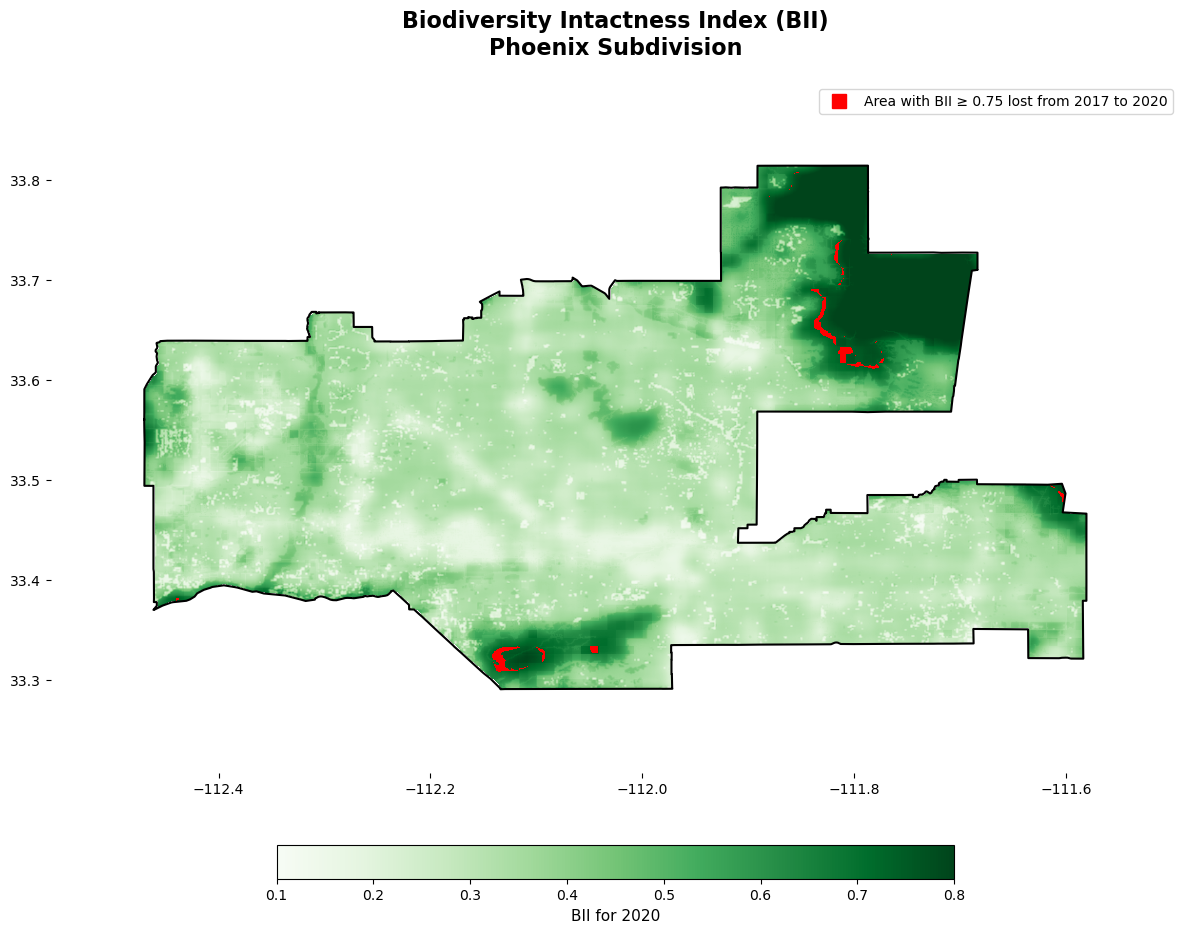

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize = (12, 10))

print(bii_2020_clipped.coords)


# Plot 2020 BII as green background
im1 = ax.imshow(
    bii_2020_clipped.squeeze().values,
    cmap = 'Greens',
    vmin = 0.1,
    vmax = 0.8,
    extent = [
        bii_2020_clipped.x.min(),
        bii_2020_clipped.x.max(),
        bii_2020_clipped.y.min(),
        bii_2020_clipped.y.max()
    ],
    aspect = 'auto',
    origin = 'upper'
)

# Create a custom colormap that's just bright red
from matplotlib.colors import ListedColormap
red_cmap = ListedColormap(['red'])

# Overlay loss areas in red
ax.imshow(
    loss_viz.values,
    cmap = red_cmap,
    vmin = 0.0,
    vmax = 1.0,
    extent = [
        loss_viz.x.min(),
        loss_viz.x.max(),
        loss_viz.y.min(),
        loss_viz.y.max()
    ],
    aspect = 'auto',
    origin = 'upper'
)

# Add Phoenix boundary
for geom in phoenix_raster_crs.geometry:
    ax.plot(*geom.exterior.xy, color='black', linewidth=1.5)

# Zoom out
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_range = x_max - x_min
y_range = y_max - y_min
ax.set_xlim(x_min - 0.10 * x_range, x_max + 0.10 * x_range)
ax.set_ylim(y_min - 0.10 * y_range, y_max + 0.10 * y_range)

# Add colorbar at bottom
cbar = plt.colorbar(im1, ax = ax, orientation = 'horizontal', pad = 0.08, shrink = 0.6)
cbar.set_label('BII for 2020', fontsize = 11)

# Title
ax.set_title('Biodiversity Intactness Index (BII)\nPhoenix Subdivision', 
             fontsize = 16, fontweight = 'bold', pad = 20)

# Regular legend
ax.plot([], [], 's', color = 'red', markersize = 10, label = 'Area with BII ≥ 0.75 lost from 2017 to 2020')
ax.legend(loc = 'upper right', frameon = True)

# Remove frame but keep axis labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

In [18]:
# Check what the dark green high-BII areas are
# Get the coordinates of the darkest green patches
dark_patches = bii_2020_clipped.squeeze().where(bii_2020_clipped.squeeze() > 0.7)

# Print rough coordinates
print(f"High BII areas located around:")
print(f"Latitude range: {dark_patches.y.min().values} to {dark_patches.y.max().values}")
print(f"Longitude range: {dark_patches.x.min().values} to {dark_patches.x.max().values}")

High BII areas located around:
Latitude range: 33.29072645787004 to 33.8135459532276
Longitude range: -112.46959767395703 to -111.58116385796282


## Results Summary

Between 2017 and 2020, 7.11% of the Phoenix subdivision had high biodiversity (BII ≥ 0.75), declining to 6.48% by 2020. This represents a 0.63 percentage point decrease over three years.

Only 0.64% of the total area (2,172 pixels) transitioned from high to low BII during this period. These losses occurred at the boundaries of two major protected areas: near the McDowell Mountains in the northeast and along South Mountain Park/Preserve in the south. The areas with highest BII values (>0.7, appearing as dark green in the visualization) correspond to these large municipal parks and preserves where natural desert habitat is maintained. Park locations were identified by cross-referencing BII coordinates with the City of Phoenix Parks and Recreation Department information and McDowell Sonoran Preserve documentation.

The small change over three years shows that Phoenix already had low biodiversity by 2017 from earlier urbanization. By 2020, only 6.48% of the area has high biodiversity, with most of it in South Mountain Park/Preserve (16,000+ acres) and the McDowell Mountains area. The loss at preserve edges shows where urban development is pushing into these protected areas.